In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e
from scipy.constants import Boltzmann as k_B
%matplotlib inline

The goal of this notebook is to illustrate the amount of power required in order to run a fusion plasma reactor. It uses material from the Chapter 4 of the book "Plasma Physics and Fusion Energy" by J.Freidberg. 

# Ideal ignition

We are looking to maintain the plasma in steady-state conditions without taking into account the overall power balance of the reactor. Ideal ignition corresponds to the condition of steady-state power balance in the plasma, assuming negligible heat conduction losses and no external heating. The fusion power $S_f$ is considered large enough to overcome the Bremsstrahlung radiation losses $S_B$:
$$S_f = S_B $$

## Fusion Alpha Power

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Deuterium-tritium_fusion.svg/330px-Deuterium-tritium_fusion.svg.png" width=200>

The alphas are charged particles that are confined by the magnetic field and thus remain within the plasma, providing a source of heat. The neutrons generated by fusion reaction are not confined in the plasma and thus do not participate to the power balance within the plasma. The fusion power is thus essentialy the alpha power : $S_f = S_\alpha$. 

Assuming a 50%-50% D-T mix with each density $n/2$, the fusion alpha power density in [$W/m^3$] is:
$$ 
S_\alpha = \frac{1}{4} E_\alpha n^2 \sigma v 
$$
where $E_\alpha$ = 3.5 MeV is the energy produced by alpha particles, $\sigma$ the cross section of the reaction and $v$ the relative velocity between the two particles. 

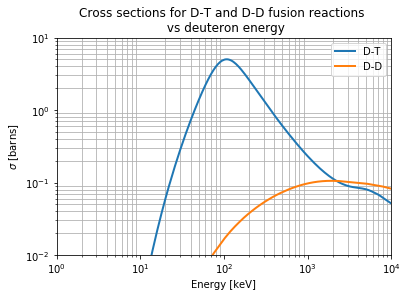

In [2]:
# Import cross-section data from http://home.earthlink.net/~jimlux/nuc/sigma.htm
data_DT=pd.read_csv('http://home.earthlink.net/~jimlux/nuc/tdn.txt', skiprows=16, delimiter='\t', 
                 names=('Energy [keV]','Sigma [Barns]'))
data_DD=pd.read_csv('http://home.earthlink.net/~jimlux/nuc/ddn.txt', skiprows=16, delimiter='\t', 
                 names=('Energy [keV]','Sigma [Barns]'))
Barn_to_msquare = 1e-28

ax=data_DT.plot(x='Energy [keV]', y='Sigma [Barns]', logy=True, logx=True, label='D-T', lw=2)
data_DD.plot(x='Energy [keV]', y='Sigma [Barns]', logy=True, logx=True, label='D-D', lw=2, ax=ax)
ax.set_ylim(10e-3, 10)
ax.set_xlim(1, 10e3)
ax.set_ylabel('$\sigma$ [barns]')
ax.grid(True, which='minor')
ax.set_title('Cross sections for D-T and D-D fusion reactions \n vs deuteron energy')

From the previous figure one notes that the D-T cross section is much larger (and thus clearly favorable) than the D-D cross section for deuteron energy below 1MeV. 

The previous equation can be generalized assuming equal temperature Maxwellian distribution functions, ie. taking the relative ion energy distribution as:
$$
N(E) = \frac{2}{\sqrt{\pi}} \theta^{-3/2} E^{1/2} \exp(-E/\theta)
$$
where $E$ is the relative energy and $\theta=k_B T$, so that the velocity averaged cross section $<\sigma v>$ is:
$$
\left<\sigma v \right>  = \left( \frac{8}{\pi} \right)^{1/2} m^{-1/2} \theta^{-3/2}  \int_0^\infty E \sigma(E) \exp(-E/\theta) dE
$$

where $<\sigma v>$ is plotted below as a function of the temperature for D-T reaction. 

The alpha fusion power is then: 
$$
S_\alpha = \frac{1}{4} E_\alpha n^2 \left<\sigma v \right>  $$

In [3]:
def sigmav_avg(T, specie='D'):
    """
    volumetric reaction rates in m^3 / s
    
    Arguments
     - T : temperature in keV
    From (Hively 1983)
    """
    return 9.1e-16 * np.exp(-0.572 * np.abs(np.log(T/64.2))**2.13) * 1e-6 

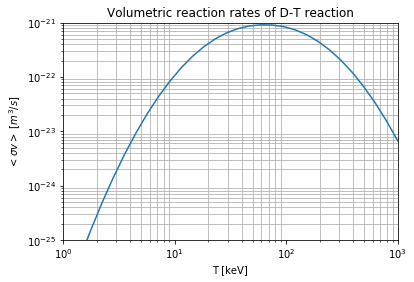

In [4]:
T = np.logspace(-2,3) # keV
sigmav = sigmav_avg(T) # m^-3 /s

fig,ax = plt.subplots()
ax.plot(T, sigmav)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('T [keV]')
ax.set_ylabel('$<\sigma v>$ [$m^3/s$]')
ax.set_xlim(1, 1e3)
ax.set_ylim(1e-25, 1e-21)
ax.grid(True, which='minor', axis='both')
ax.set_title('Volumetric reaction rates of D-T reaction')

Recalling that the total pressure is $p = 2 n T$, the previous equation can be written in terms of $p$ as follows: 
$$
\boxed{
S_\alpha = \frac{E_\alpha}{16}  \frac{p^2}{T^2} \left<\sigma v \right> 
}$$


## Radiation Losses

Of the multiple losses mechanisms, the Bremsstrahlung radiation due to Coulomb collisions is the largest. In terms of practical units ($T$ in keV, $n$ in $10^{20} m^{-3}$) the losses in [$W/m^3$] are:
$$
S_B = C_B Z_{\mathrm{eff}} n^2 T^{1/2}
$$
with $C_B=5.35\times10^3$ and $Z_{\mathrm{eff}}$ the _effective charge_ of all the ions, defined as
$$
Z_{\mathrm{eff}} = \frac{\sum_j Z_j^2 n_j}{n_e}
$$
Again, rewritting in terms of pressures:

$$
\boxed{
S_B = \frac{1}{4} C_B Z_{\mathrm{eff}} \frac{p^2}{T^{3/2}} 
}
$$
If a high degree of plasma purity is assumed, $Z_{\mathrm{eff}}\approx 1$. 

## Power Balance

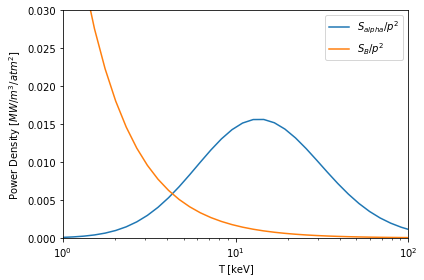

In [18]:
# Taken from Eqs.(4.18) J.Freidberg
def S_alpha_over_p(T):
    "T in keV"
    #E_alpha = 3.5 # MeV
    #return 1/16*(E_alpha*1e6/e)/(T/e*k_B)**2*sigmav_avg(T/1e3)
    return 1.37*sigmav_avg(T)/1e-22/T**2
    
def S_B_over_p(T, Z_eff=1):
    "T in keV"
    return 0.052/T**(3/2)

T = np.logspace(0,3) # keV
S_a = S_alpha_over_p(T) 
S_B = S_B_over_p(T)


fig, ax = plt.subplots()
ax.plot(T, S_a, label='$S_{alpha}/p^2$')
ax.plot(T, S_B, label='$S_B/p^2$')
ax.set_ylim(0, 0.03)
ax.set_xlim(1, 100)
ax.set_xscale('log')
ax.set_xlabel('T [keV]')
ax.set_ylabel('Power Density [$MW/m^3/atm^2$]')
ax.legend()
fig.tight_layout()

Once the ignition temperature is exceed (~4-5 keV), alpha power increases faster than losses. 